#### claim: I don't think the idea of forecast crime is ethical, the code below is just used to test the model 

In [1]:
import numpy as np
import pandas as pd
import warnings
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\chao_gu\Anaconda3\envs\stats\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### import data file

In [2]:
df = pd.read_csv('./Data/Police_Incidents_Final.csv')

C:\Users\chao_gu\Anaconda3\envs\stats\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.iloc[0]

Incident Number                                090033416
Date Occurred                                 2009-04-02
UCR                                                 1823
UCR Description                  Narco Possess-Synthetic
Location                        1600BLK OCEAN FRONT WALK
Gang Related                                       False
Latitude                                         34.0103
Longitude                                       -118.496
Map Point          (34.0102977457032, -118.495738552074)
Line_Open                                          False
Month                                                  4
Year                                                2009
Day_Of_Week                                            3
Day_Delta                                          -2605
UCR Level 2                                    Narcotics
UCR Level 1                                  Non-Violent
one_mile                                               1
half_mile                      

#### data processing

In [3]:
import datetime

In [4]:
df['Incident Date'] = df['Date Occurred'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))

In [5]:
df['Incident Date'].isnull().sum()

0

In [6]:
df_month=df.groupby(['Year','Month'])['Month'].count()

In [7]:
time = [(lambda year,month: datetime.datetime(year,month,1))(year,month) for year,month in df_month.index.values]
time_index = pd.Series(time)
df_month.index = time_index

#### function for data stationary test

In [8]:
from statsmodels.tsa.stattools import adfuller
def dickey_fuller_test(df):
    df_test = adfuller(df,autolag = 'AIC')
    test_result = pd.Series(df_test[0:4],
                       index = ['Test Statistic',
                               'p-vale',
                               '#Lags Used',
                               'Mumber of Observation Used'])
    for key,value in df_test[4].items():
        test_result['Critical Value (%s)'%key] = value
    return test_result

In [9]:
def plot_stat_graph(df,window = 12):
    fig = plt.figure(figsize=(20,10))
    rolstd = pd.Series.rolling(df,window = window).std()
    rolmean = pd.Series.rolling(df,window = window).mean()
    
    plt.plot(df.index,df,color = 'blue',label = 'Original')
    plt.plot(rolstd.index,rolstd,color = 'orange',label = 'Rolling Std')
    plt.plot(rolmean.index,rolmean,color = 'red',label = 'Rolling Mean')
    
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Rolling Standard Deviation')
    
    plt.show()

In [10]:
def data_info(df,window = 12):
    plot_stat_graph(df,window)
    result = dickey_fuller_test(df)
    print(result)
    return

### Data Analysis with SARIMA

In [11]:
opendate = datetime.datetime(2016,5,1)

In [12]:
#create the dataframe for the data before the opening of the station
pre_df = df_month[df_month.index<opendate]

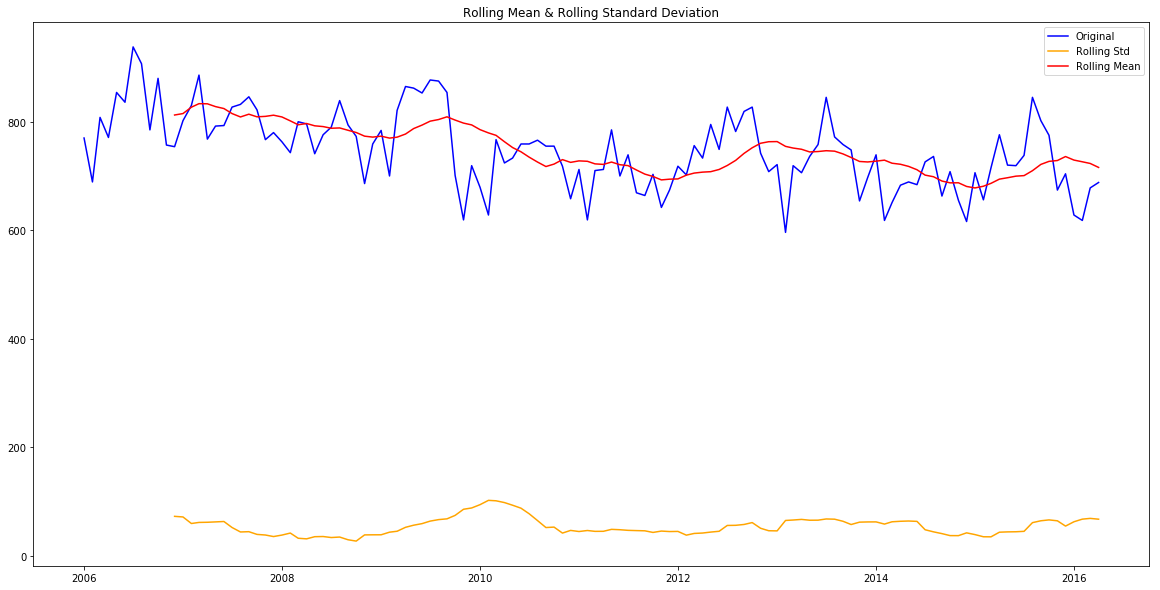

Test Statistic                 -1.685638
p-vale                          0.438527
#Lags Used                     12.000000
Mumber of Observation Used    111.000000
Critical Value (1%)            -3.490683
Critical Value (5%)            -2.887952
Critical Value (10%)           -2.580857
dtype: float64


In [13]:
data_info(pre_df)

#### try use difference of data points

In [14]:
diff = pre_df - pre_df.shift()
diff = diff.dropna()

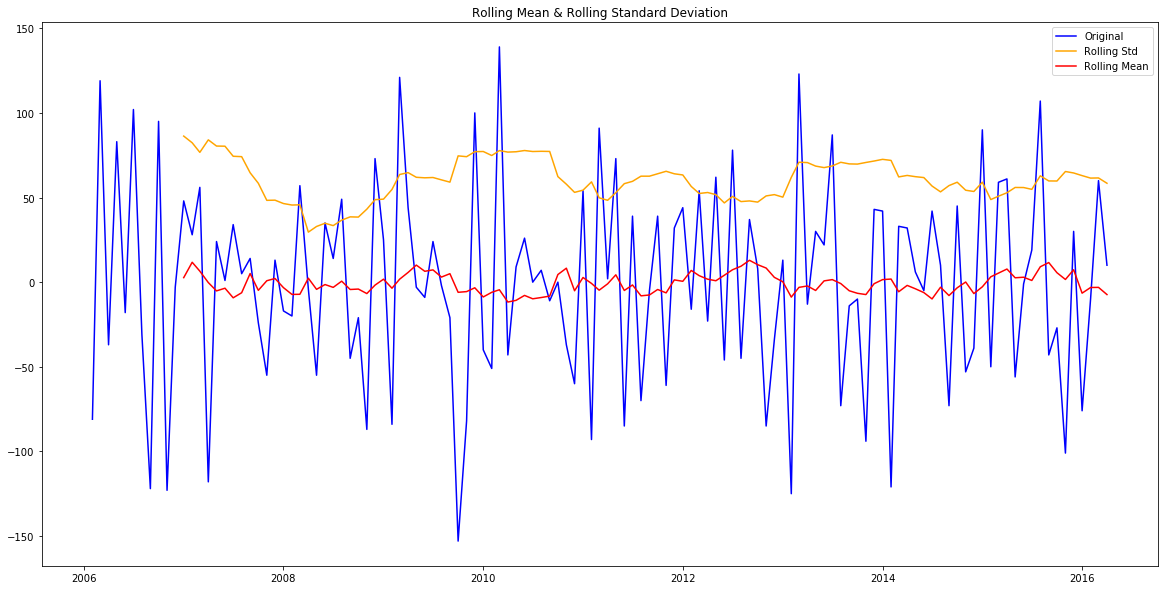

Test Statistic                 -4.859777
p-vale                          0.000042
#Lags Used                     11.000000
Mumber of Observation Used    111.000000
Critical Value (1%)            -3.490683
Critical Value (5%)            -2.887952
Critical Value (10%)           -2.580857
dtype: float64


In [15]:
data_info(diff)

#### grid search for SARIMA model 

In [16]:
modelselection = pd.DataFrame(columns = ['order','seasonal','aic'])

In [17]:
p=q=range(1,5)
d=D=1
pq = list(itertools.product(p,q))
pdq = [(x[0],d,x[1]) for x in pq]
seasonal_pdq = [(x[0],D,x[1],12) for x in pq]

In [19]:
%%time
warnings.filterwarnings('ignore') #ignore warning message

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(diff,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,  
                                            enforce_invertibility = False)
            result = mod.fit().aic
            data = pd.DataFrame([[str(param),str(param_seasonal),result]],
                                columns = modelselection.columns)
            modelselection = modelselection.append(data, ignore_index = True)

        except:
#             print('error')
            continue

Wall time: 1h 14min 5s


In [21]:
modelselection.loc[modelselection['aic'].idxmin()]

order           (4, 1, 1)
seasonal    (4, 1, 1, 12)
aic               624.588
Name: 153, dtype: object

#### use SARIMA model with optimal parameter 

In [18]:
SARIMA_411_411 = sm.tsa.statespace.SARIMAX(diff,
                                order = (4,1,1),
                                seasonal_order = (4,1,1,12),
                                enforce_stationarity = False,
                                enforce_invertibility = False).fit()

In [19]:
SARIMA_411_411.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Month   No. Observations:                  123
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -301.294
Date:                            Fri, 16 Feb 2018   AIC                            624.588
Time:                                    16:25:27   BIC                            655.522
Sample:                                02-01-2006   HQIC                           637.154
                                     - 04-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4289      0.177     -2.416      0.016      -0.777      -0.081
ar.L2         -0.0632      0.182     -0.348      0.728      -0.419       0.293
ar.L3         -0.0780      0.180     -0.433      0.665      -0.431       0.275
ar.L4         -0.1119      0.197     -0.567      0.571      -0.498       0.275
ma.L1         -1.0000      0.267     -3.744      0.000      -1.523      -0.477
ar.S.L12      -0.1876      0.351     -0.534      0.593      -0.876       0.501
ar.S.L24      -0.2906      0.165     -1.759      0.079      -0.614       0.033
ar.S.L36      -0.1225      0.171     -0.717      0.473      -0.457       0.212
ar.S.L48      -0.1880      0.153     -1.231      0.218      -0.487       0.111
ma.S.L12      -0.7005      0.488     -1.436      0.151      -1.656       0.255
sigma2      1613.8301      0.000   9.75e+06      0.000    1613.830    1613.830
===================================================================================
Ljung-Box (Q):                       39.57   Jarque-Bera (JB):                 0.36
Prob(Q):                              0.49   Prob(JB):                         0.83
Heteroskedasticity (H):               2.50   Skew:                            -0.17
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.37e+23. Standard errors may be unstable.
"""

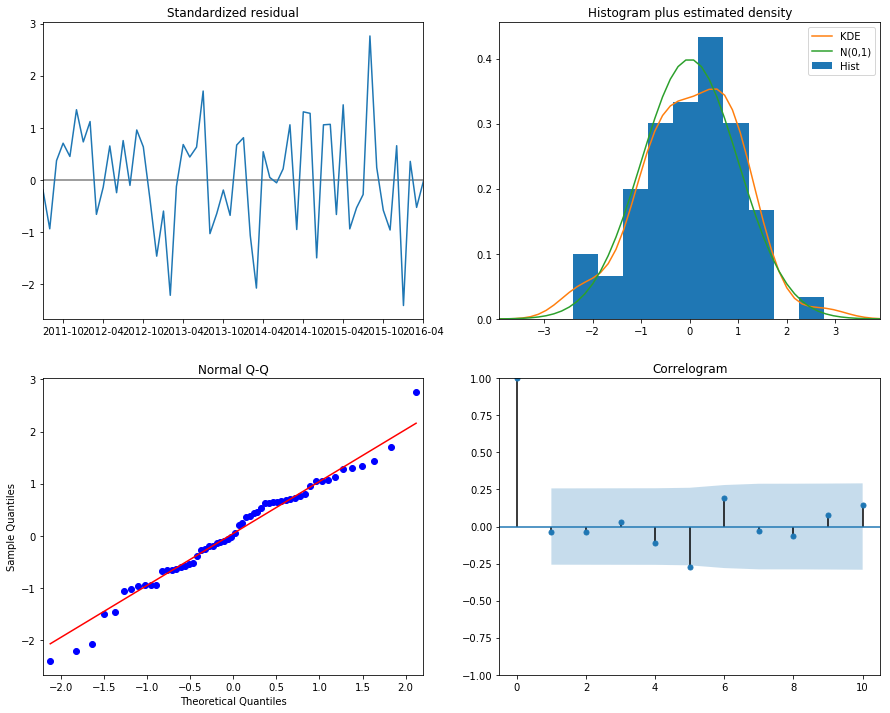

In [20]:
SARIMA_411_411.plot_diagnostics(figsize = (15,12))
plt.show()

In [21]:
pred = SARIMA_411_411.get_prediction()
pred_ci = pred.conf_int()

In [22]:
forecast = SARIMA_411_411.forecast(steps = 21)

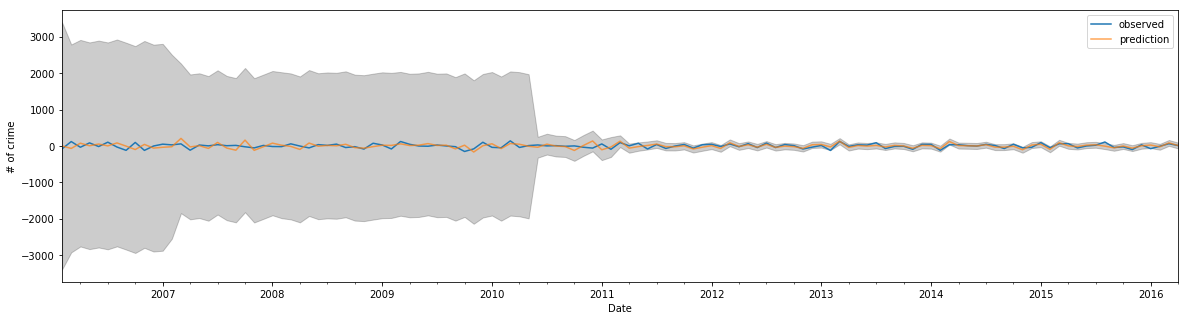

In [23]:
fig = plt.figure(figsize=(20,5))
ax = diff.plot(label = 'observed')
pred.predicted_mean.plot(ax = ax, label = 'prediction', alpha = .7)

ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],
               color = 'k',
               alpha = .2)

ax.set_xlabel('Date')
ax.set_ylabel('# of crime')
plt.legend()
plt.show()

In [24]:
pred_result = pd.Series(pred.predicted_mean)

pred_result = pred_result.append(forecast)

In [25]:
cum_diff = pred_result.cumsum()

In [26]:
prediction = pd.Series(df_month.ix[0],index = df_month.index)

C:\Users\chao_gu\Anaconda3\envs\stats\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [27]:
prediction = prediction.add(cum_diff)

In [28]:
prediction.ix[0] = df_month.ix[0]

C:\Users\chao_gu\Anaconda3\envs\stats\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


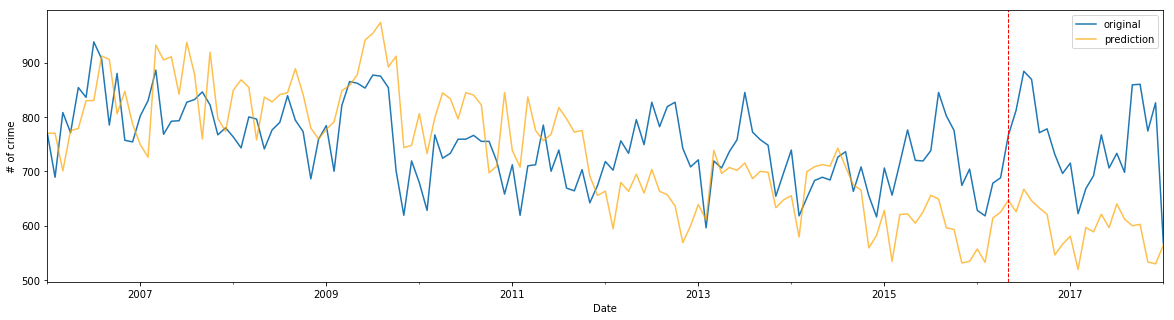

In [29]:
fig = plt.figure(figsize=(20,5))
ax = df_month.plot(label = 'original')
prediction.plot(ax = ax, label = 'prediction', alpha = .7,color = 'orange')
ax.set_xlabel('Date')
ax.set_ylabel('# of crime')

ax.axvline(opendate,ls='--',lw = 1,color = 'r')


plt.legend()
plt.show()


### Data Analysis with Prophet 

In [30]:
from fbprophet import Prophet

In [31]:
df_fb = pd.DataFrame()
df_fb['ds'] = pre_df.index
df_fb['y'] = pre_df.values

In [32]:
m = Prophet()
m.fit(df_fb)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [33]:
future = m.make_future_dataframe(periods = 21, freq = 'MS',include_history = True)
forecast = m.predict(future)

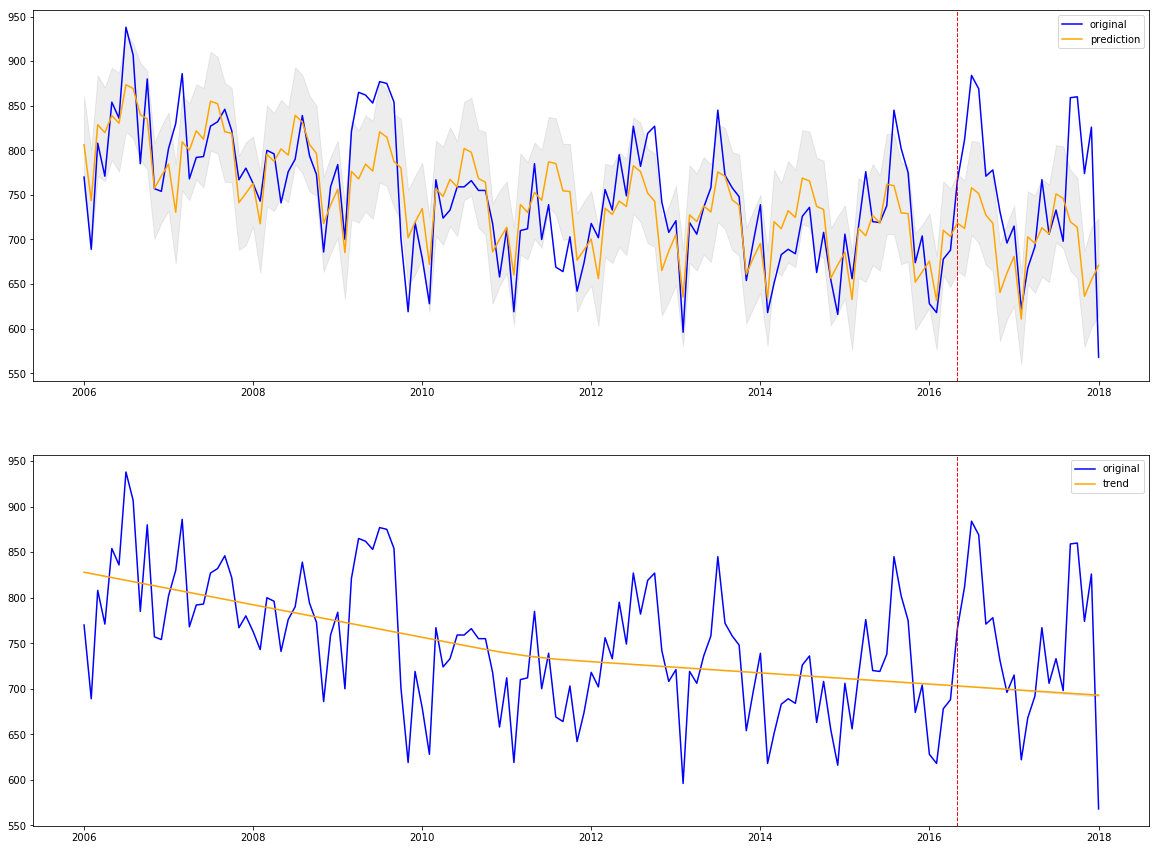

In [34]:
fig = plt.figure(figsize = (20,15))
plt.subplot(2,1,1)
plt.plot(df_month.index,df_month,color = 'blue',label = 'original')
plt.plot(forecast['ds'],forecast['yhat'],color = 'orange',label = 'prediction')

plt.fill_between(df_month.index,
                 forecast['yhat_lower'],
                 forecast['yhat_upper'],
                 color = 'k',
                alpha = .07)
plt.axvline(opendate, ls = '--',lw = 1,color = 'r')
plt.legend(loc = 'best')

plt.subplot(2,1,2)
plt.plot(df_month.index,df_month,color = 'blue',label = 'original')
plt.plot(forecast['ds'],forecast['trend'],color = 'orange',label = 'trend')

plt.fill_between(df_month.index,
                 forecast['trend_lower'],
                 forecast['trend_upper'],
                 color = 'k',
                alpha = .07)
plt.axvline(opendate, ls = '--',lw = 1,color = 'r')
plt.legend(loc = 'best')

plt.show()

### Prediction Comparison

In [35]:
#seperate data
post_df = df_month[df_month.index>=opendate]
prophet = forecast[forecast['ds']>=opendate]
SARIMAX = prediction[prediction.index >= opendate]

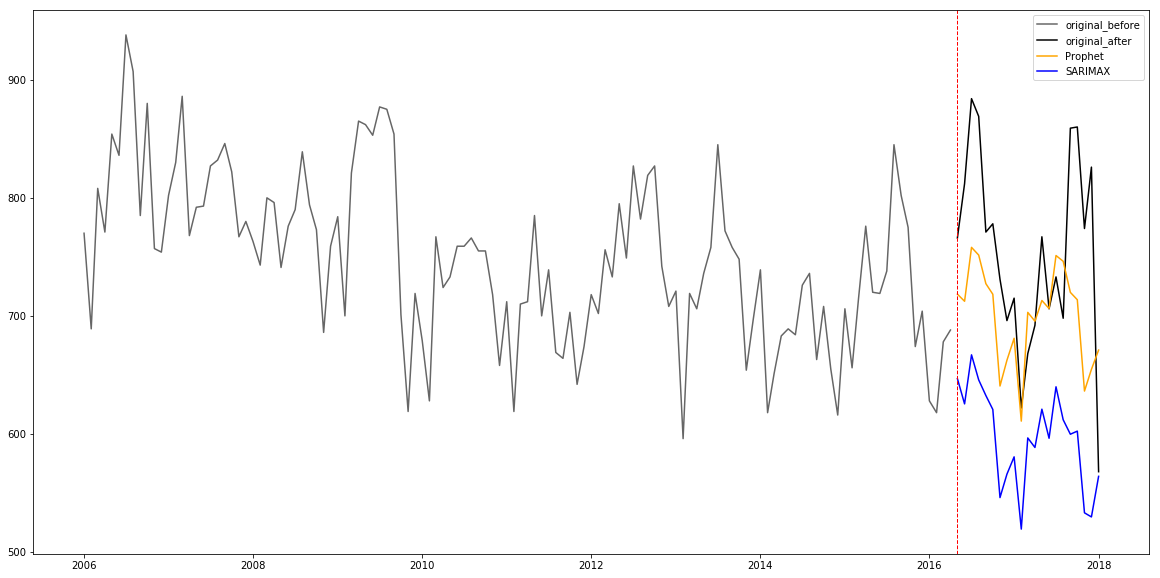

In [36]:
fig = plt.figure(figsize=(20,10))
#original data before the opening of the station
plt.plot(pre_df.index,pre_df,color = 'k',alpha = 0.6,label = 'original_before')
#original data after the opening of the station
plt.plot(post_df.index,post_df,color = 'k',label = 'original_after')
#prediction by fb prophet
plt.plot(prophet['ds'],prophet['yhat'],color = 'orange',label = 'Prophet')
#prediction by sarimax
plt.plot(SARIMAX.index,SARIMAX,color = 'blue',label = 'SARIMAX')
#add vline for opendate
plt.axvline(opendate,color = 'r', ls = '--', lw=1)

plt.legend(loc = 'best')
plt.show()

### prophet changing point analysis 

In [37]:
deltas = m.params['delta']
points = m.changepoints.copy()
cp = points.reset_index()

In [38]:
deltas = deltas.reshape(-1,1)

In [39]:
cp['delta'] = deltas

In [40]:
cp_sort = cp.sort_values(by='delta',ascending = False)

In [41]:
cp_sort.reset_index(drop=True)

,index,ds,delta
0,63,2011-04-01,3.961676e-02
1,67,2011-08-01,3.824185e-02
2,59,2010-12-01,3.073560e-02
3,55,2010-08-01,1.356333e-02
4,71,2011-12-01,5.911676e-03
5,51,2010-04-01,1.043031e-07
6,75,2012-04-01,4.998989e-08
7,48,2010-01-01,2.639850e-08
8,91,2013-08-01,1.558881e-08
9,28,2008-05-01,1.134221e-08


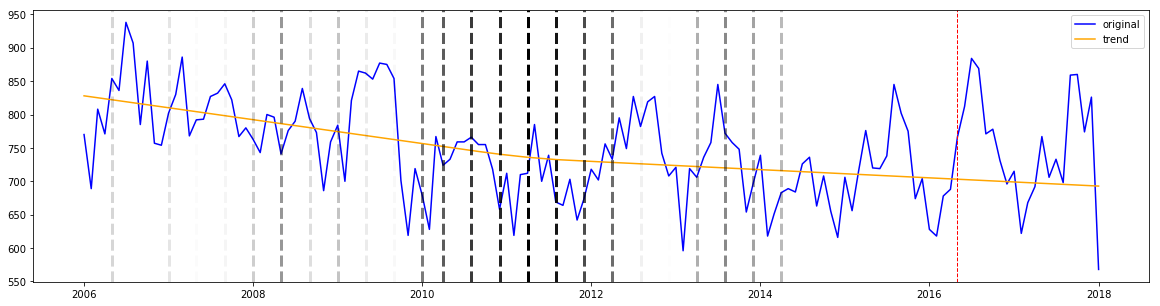

In [42]:
fig = plt.figure(figsize = (20,5))
plt.plot(df_month.index,df_month,color = 'b', label = 'original')
plt.plot(forecast['ds'],forecast['trend'],color = 'orange',label = 'trend')

n = cp_sort.shape[0]
for i in range(0,n):
    plt.axvline(cp_sort['ds'].iloc[i], color = 'k',alpha = ((n-i)/n)**2 ,ls = '--',lw = 3)
plt.axvline(opendate,color = 'r',ls = '--',lw=1)

plt.legend()
plt.show()

In [43]:
m.params

{'beta': array([[ 0.00024299, -0.04732032,  0.01884503,  0.00788097,  0.00792995,
          0.03079192,  0.01694184,  0.04557518,  0.00560571,  0.00210729,
          0.02762477,  0.00506502,  0.02247847,  0.00131252,  0.02973294,
         -0.03001415,  0.0195538 , -0.03010672,  0.00561988, -0.00856774]]),
 'delta': array([[ -1.71022356e-09,  -1.76526956e-08,  -4.21657966e-09,
          -1.49811268e-08,  -8.11854312e-09,   1.08616628e-10,
           1.13422141e-08,  -3.95260010e-09,   2.09978869e-09,
          -4.29030224e-09,  -9.20013153e-09,   2.63985029e-08,
           1.04303064e-07,   1.35633339e-02,   3.07355976e-02,
           3.96167564e-02,   3.82418546e-02,   5.91167605e-03,
           4.99898940e-08,  -7.00080013e-09,  -1.56141812e-08,
           4.93237213e-09,   1.55888109e-08,   5.68884813e-09,
           4.13452049e-09]]),
 'gamma': array([[  5.48295024e-11,   1.14603394e-09,   4.11181292e-10,
           1.94118261e-09,   1.31874812e-09,  -2.11835796e-11,
          -2.57

In [45]:
prediction

2006-01-01    770.000000
2006-02-01    770.000000
2006-03-01    700.579128
2006-04-01    775.011282
2006-05-01    778.599784
2006-06-01    829.801454
2006-07-01    830.206456
2006-08-01    911.949369
2006-09-01    905.786364
2006-10-01    805.867782
2006-11-01    847.123342
2006-12-01    786.924504
2007-01-01    748.750557
2007-02-01    725.922364
2007-03-01    932.201543
2007-04-01    904.733527
2007-05-01    910.698616
2007-06-01    841.699466
2007-07-01    937.124413
2007-08-01    878.082821
2007-09-01    759.425320
2007-10-01    919.120129
2007-11-01    797.107815
2007-12-01    773.346299
2008-01-01    849.283718
2008-02-01    868.222604
2008-03-01    854.446249
2008-04-01    757.742306
2008-05-01    836.476561
2008-06-01    827.567396
                 ...    
2015-08-01    648.905266
2015-09-01    596.070260
2015-10-01    592.936551
2015-11-01    531.359834
2015-12-01    534.293735
2016-01-01    557.085428
2016-02-01    532.396141
2016-03-01    613.906637
2016-04-01    624.794008


In [53]:
prophet_result = forecast.yhat

In [54]:
prophet_result.index = forecast.ds

In [55]:
prophet_result

ds
2006-01-01    806.149741
2006-02-01    743.582153
2006-03-01    828.692149
2006-04-01    819.778026
2006-05-01    838.962455
2006-06-01    830.342607
2006-07-01    873.568866
2006-08-01    869.306471
2006-09-01    839.864833
2006-10-01    835.422511
2006-11-01    757.366253
2006-12-01    771.322255
2007-01-01    784.483217
2007-02-01    730.533446
2007-03-01    809.374184
2007-04-01    800.109262
2007-05-01    821.895482
2007-06-01    812.466190
2007-07-01    854.955191
2007-08-01    852.317602
2007-09-01    820.792843
2007-10-01    819.090053
2007-11-01    741.302315
2007-12-01    751.770926
2008-01-01    762.888536
2008-02-01    717.559522
2008-03-01    795.541680
2008-04-01    787.632110
2008-05-01    801.635852
2008-06-01    794.579034
                 ...    
2015-08-01    760.322169
2015-09-01    729.792335
2015-10-01    729.052374
2015-11-01    652.259561
2015-12-01    663.691002
2016-01-01    675.803536
2016-02-01    631.469447
2016-03-01    710.382341
2016-04-01    703.4676

In [56]:
df_month

2006-01-01    770
2006-02-01    689
2006-03-01    808
2006-04-01    771
2006-05-01    854
2006-06-01    836
2006-07-01    938
2006-08-01    907
2006-09-01    785
2006-10-01    880
2006-11-01    757
2006-12-01    754
2007-01-01    802
2007-02-01    830
2007-03-01    886
2007-04-01    768
2007-05-01    792
2007-06-01    793
2007-07-01    827
2007-08-01    832
2007-09-01    846
2007-10-01    822
2007-11-01    767
2007-12-01    780
2008-01-01    763
2008-02-01    743
2008-03-01    800
2008-04-01    796
2008-05-01    741
2008-06-01    776
             ... 
2015-08-01    845
2015-09-01    802
2015-10-01    775
2015-11-01    674
2015-12-01    704
2016-01-01    628
2016-02-01    618
2016-03-01    678
2016-04-01    688
2016-05-01    766
2016-06-01    812
2016-07-01    884
2016-08-01    869
2016-09-01    771
2016-10-01    778
2016-11-01    731
2016-12-01    696
2017-01-01    715
2017-02-01    622
2017-03-01    668
2017-04-01    692
2017-05-01    767
2017-06-01    706
2017-07-01    733
2017-08-01

In [61]:
data = pd.concat([df_month,prediction,prophet_result],axis = 1)

In [63]:
data.columns = ['original','SARIMA','Prophet']

In [65]:
data.to_csv('./Data/prediction on crime dataset.csv')